# ECG5000 Classification Project
## CRISP-DM Methodology

Project ini melakukan klasifikasi sinyal ECG menggunakan dataset ECG5000 dengan pendekatan CRISP-DM (Cross-Industry Standard Process for Data Mining).

---
# 1. Business Understanding

## 1.1 Tujuan Proyek
Mengembangkan sistem deteksi dini aritmia jantung melalui klasifikasi sinyal ECG (Elektrokardiogram) secara otomatis untuk mendukung diagnosis medis.

## 1.2 Tujuan Analisis
- Memahami pola sinyal ECG normal vs abnormal dengan 140 titik waktu per sampel
- Membangun model klasifikasi binary dengan fokus pada minimalisir false negative
- Mengidentifikasi karakteristik temporal dan fitur penting dalam sinyal ECG
- Menghasilkan model yang reliable untuk deployment dalam konteks medis

## 1.3 Latar Belakang
Penyakit jantung adalah salah satu penyebab kematian utama di dunia. Aritmia atau kelainan irama jantung dapat mengancam jiwa jika tidak terdeteksi dini. Analisis ECG secara otomatis dapat membantu tenaga medis dalam mendeteksi anomali jantung lebih cepat dan akurat, mengurangi beban kerja, dan meningkatkan akses layanan kesehatan.

## 1.4 Success Criteria
- **Akurasi keseluruhan** ≥ 90%
- **Recall untuk kelas Abnormal** ≥ 95% (prioritas utama untuk menghindari false negative)
- **F1-Score** ≥ 92% (keseimbangan precision dan recall)
- Model stabil dengan cross-validation std < 3%

## 1.5 Risiko dan Pertimbangan Medis
- False Negative (miss detection abnormalitas) = risiko tinggi, dapat membahayakan pasien
- False Positive (over-detection) = risiko rendah, hanya perlu konfirmasi lanjutan
- Oleh karena itu, model dirancang dengan bias mendeteksi lebih sensitif terhadap abnormalitas

---
# 2. Data Understanding

## 2.1 Deskripsi Dataset

### Sumber Data

Dataset **ECG5000** berasal dari **UCR Time Series Classification Archive**, repositori yang sering dipakai sebagai benchmark untuk riset klasifikasi sinyal. Dataset ini disusun oleh peneliti dari University of California, Riverside.

### Berisi 5000 Sampel

Dataset ECG5000 berisi **5000 detak jantung yang semuanya diambil dari pasien**. Proses pengumpulannya:

- Data berasal dari rekaman ECG panjang dari **BIDMC Congestive Heart Failure Database**
- Rekaman berlangsung sekitar **20 jam tanpa putus** (kontinyu)
- Rekaman panjang tersebut **dipotong menjadi detak jantung individual**
- Setiap detak mewakili kondisi jantung pasien pada waktu berbeda selama periode 20 jam
- Dari seluruh detak yang tersedia, **dipilih 5000 detak** untuk membentuk dataset penelitian time series

### Proses Pengumpulan Data

Tahap pengumpulan dan persiapan data dilakukan dengan langkah berikut:

1. **Perekaman ECG**: Sinyal ECG direkam menggunakan **Holter monitor**, alat portabel yang merekam aktivitas listrik jantung secara kontinyu selama 20 jam
2. **Segmentasi**: Rekaman ECG panjang dipotong menjadi segmen-segmen individual yang masing-masing mewakili **satu siklus detak jantung (heartbeat)**
3. **Sampling**: Setiap segmen heartbeat di-sampling ulang (**resampling**) menjadi **140 titik data** dengan interval waktu yang sama
4. **Normalisasi**: Amplitudo sinyal dinormalisasi untuk menghilangkan variasi baseline dan memfasilitasi analisis

### Terdapat 140 Fitur

Setiap sampel memiliki panjang 140. Panjang ini menunjukkan jumlah titik waktu yang menyusun satu heartbeat.

- **Fitur tunggal yang direkam adalah amplitudo sinyal ECG**
- Nilai amplitudo ini disimpan dalam urutan sepanjang 140 time steps
- Urutan tersebut membentuk satu heartbeat lengkap, dari awal hingga akhir

Dengan demikian, bentuk data satu sampel adalah vektor 140 nilai:

`[ecg_0, ecg_1, …, ecg_139]`

### Struktur Label 5 Kelas

Dataset terdiri dari **5 kelas heartbeat** berdasarkan anotasi medis:

| Kelas | Nama | Deskripsi |
|-------|------|-----------|
| **1** | Normal (N) | Detak jantung dengan ritme sinus normal |
| **2** | R-on-T PVC | Premature Ventricular Contraction yang terjadi pada gelombang T (berbahaya) |
| **3** | Supraventricular Ectopic Beat (S) | Detak ektopik yang berasal dari atrium |
| **4** | Premature Ventricular Contraction (V) | Kontraksi ventrikel prematur |
| **5** | Unknown/Fusion Beat (F) | Detak yang tidak dapat diklasifikasi atau fusion beat |

**Catatan Medis:**
- **Kelas 1 (Normal)** adalah detak jantung sehat dengan pola P-QRS-T yang teratur
- **Kelas 2-5 (Abnormal)** merupakan berbagai jenis aritmia yang memerlukan perhatian medis
- Distribusi kelas tidak seimbang karena sebagian besar waktu jantung berfungsi normal

### Komposisi Dataset

- **Total sampel**: 5000 heartbeat (dari 1 pasien, rekaman 20 jam)
- **Training set awal**: 500 sampel
- **Test set awal**: 4500 sampel
- **Panjang deret waktu per sampel**: 140 time steps
- **Jumlah kelas**: 5 kelas
- **Format file**: Berupa teks dengan spasi. Kolom pertama adalah label kelas (1-5), diikuti 140 nilai amplitudo

### Konteks Medis

Dataset ini sangat relevan untuk:
- Penelitian **deteksi aritmia otomatis** pada pasien gagal jantung
- Pengembangan **sistem monitoring jantung real-time**
- Klasifikasi **jenis-jenis aritmia** spesifik
- Validasi algoritma **klasifikasi time series** pada data medis riil

## 2.2 Load dan Eksplorasi Data

Bagian ini memuat proses pembacaan data, konversi ke DataFrame, pengecekan ukuran data, tipe data, jumlah kelas, dan pemeriksaan sampel awal.

In [1]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import warnings
warnings.filterwarnings('ignore')

# Set style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('husl')

In [2]:
# Load data
train_data = np.loadtxt('ECG5000_TRAIN.txt')
test_data = np.loadtxt('ECG5000_TEST.txt')

print(f'Training data shape: {train_data.shape}')
print(f'Test data shape: {test_data.shape}')

Training data shape: (500, 141)
Test data shape: (4500, 141)


In [3]:
# Gabung data train dan test
all_data = np.vstack([train_data, test_data])
print(f'Total data shape: {all_data.shape}')

# Pisahkan features dan label
# Kolom pertama adalah label
y = all_data[:, 0].astype(int)
X = all_data[:, 1:]

print(f'\nFeatures shape: {X.shape}')
print(f'Labels shape: {y.shape}')

Total data shape: (5000, 141)

Features shape: (5000, 140)
Labels shape: (5000,)


In [4]:
# Konversi ke DataFrame
feature_names = [f'ecg_{i}' for i in range(X.shape[1])]
df = pd.DataFrame(X, columns=feature_names)
df['label'] = y

print('Dataset Info:')
print(df.info())
print('\nStatistik Deskriptif:')
df.describe()

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Columns: 141 entries, ecg_0 to label
dtypes: float64(140), int64(1)
memory usage: 5.4 MB
None

Statistik Deskriptif:


,ecg_0,ecg_1,ecg_2,ecg_3,ecg_4,ecg_5,ecg_6,ecg_7,ecg_8,ecg_9,...,ecg_131,ecg_132,ecg_133,ecg_134,ecg_135,ecg_136,ecg_137,ecg_138,ecg_139,label
count,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,...,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000
mean,-0.262476,-1.649511,-2.492211,-3.119443,-3.167438,-2.866308,-2.273126,-1.798127,-1.410124,-0.936082,...,0.070973,-0.062914,-0.276206,-0.507667,-0.761043,-0.834741,-0.642263,-0.487242,-0.706008,1.527400
std,1.152369,1.445493,1.386409,1.302802,1.104382,0.906133,0.731627,0.623100,0.637149,0.657945,...,1.404842,1.646585,1.895134,2.059758,2.086218,2.056220,1.859296,1.830987,1.414465,0.760372
min,-6.729499,-7.090374,-5.132459,-5.363241,-5.375715,-5.330194,-4.782240,-4.311288,-4.071361,-4.142476,...,-4.167040,-4.557576,-4.530488,-4.563270,-5.150100,-4.880460,-5.496107,-5.880890,-6.092227,1.000000
25%,-1.004511,-2.701576,-3.668096,-4.227247,-4.007470,-3.480479,-2.779941,-2.165851,-1.774124,-1.362068,...,-1.089300,-1.588885,-2.147449,-2.731550,-3.030509,-2.868331,-2.153513,-1.657771,-1.596692,1.000000
50%,-0.297541,-1.661892,-2.585677,-3.387934,-3.468718,-2.947061,-2.285578,-1.750157,-1.422570,-0.910487,...,0.658318,0.717808,0.604747,0.334857,-0.030767,-0.195151,-0.194423,-0.160262,-0.565588,1.000000
75%,0.500061,-0.677290,-1.513964,-2.235369,-2.530967,-2.398813,-1.823494,-1.484923,-1.063708,-0.476660,...,1.169420,1.238687,1.264471,1.234433,1.034584,0.945237,0.951681,1.002692,0.272012,2.000000
max,4.966414,3.479689,2.660597,1.899798,2.147015,1.614375,1.868728,1.804251,1.683730,1.898627,...,3.007606,2.854680,2.912394,2.937685,3.351437,3.432519,3.579448,4.425976,7.402103,5.000000


Distribusi Label:
1    2919
2    1767
3      96
4     194
5      24
Name: count, dtype: int64


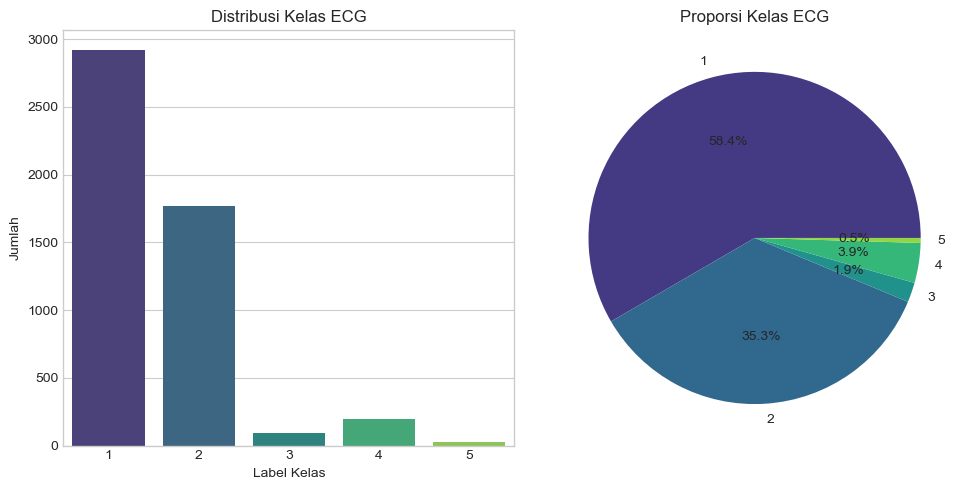

In [5]:
# Distribusi label
print('Distribusi Label:')
label_counts = pd.Series(y).value_counts().sort_index()
print(label_counts)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
sns.countplot(x=y, palette='viridis')
plt.title('Distribusi Kelas ECG')
plt.xlabel('Label Kelas')
plt.ylabel('Jumlah')

plt.subplot(1, 2, 2)
plt.pie(label_counts.values, labels=label_counts.index, autopct='%1.1f%%', colors=sns.color_palette('viridis', len(label_counts)))
plt.title('Proporsi Kelas ECG')
plt.tight_layout()
plt.show()

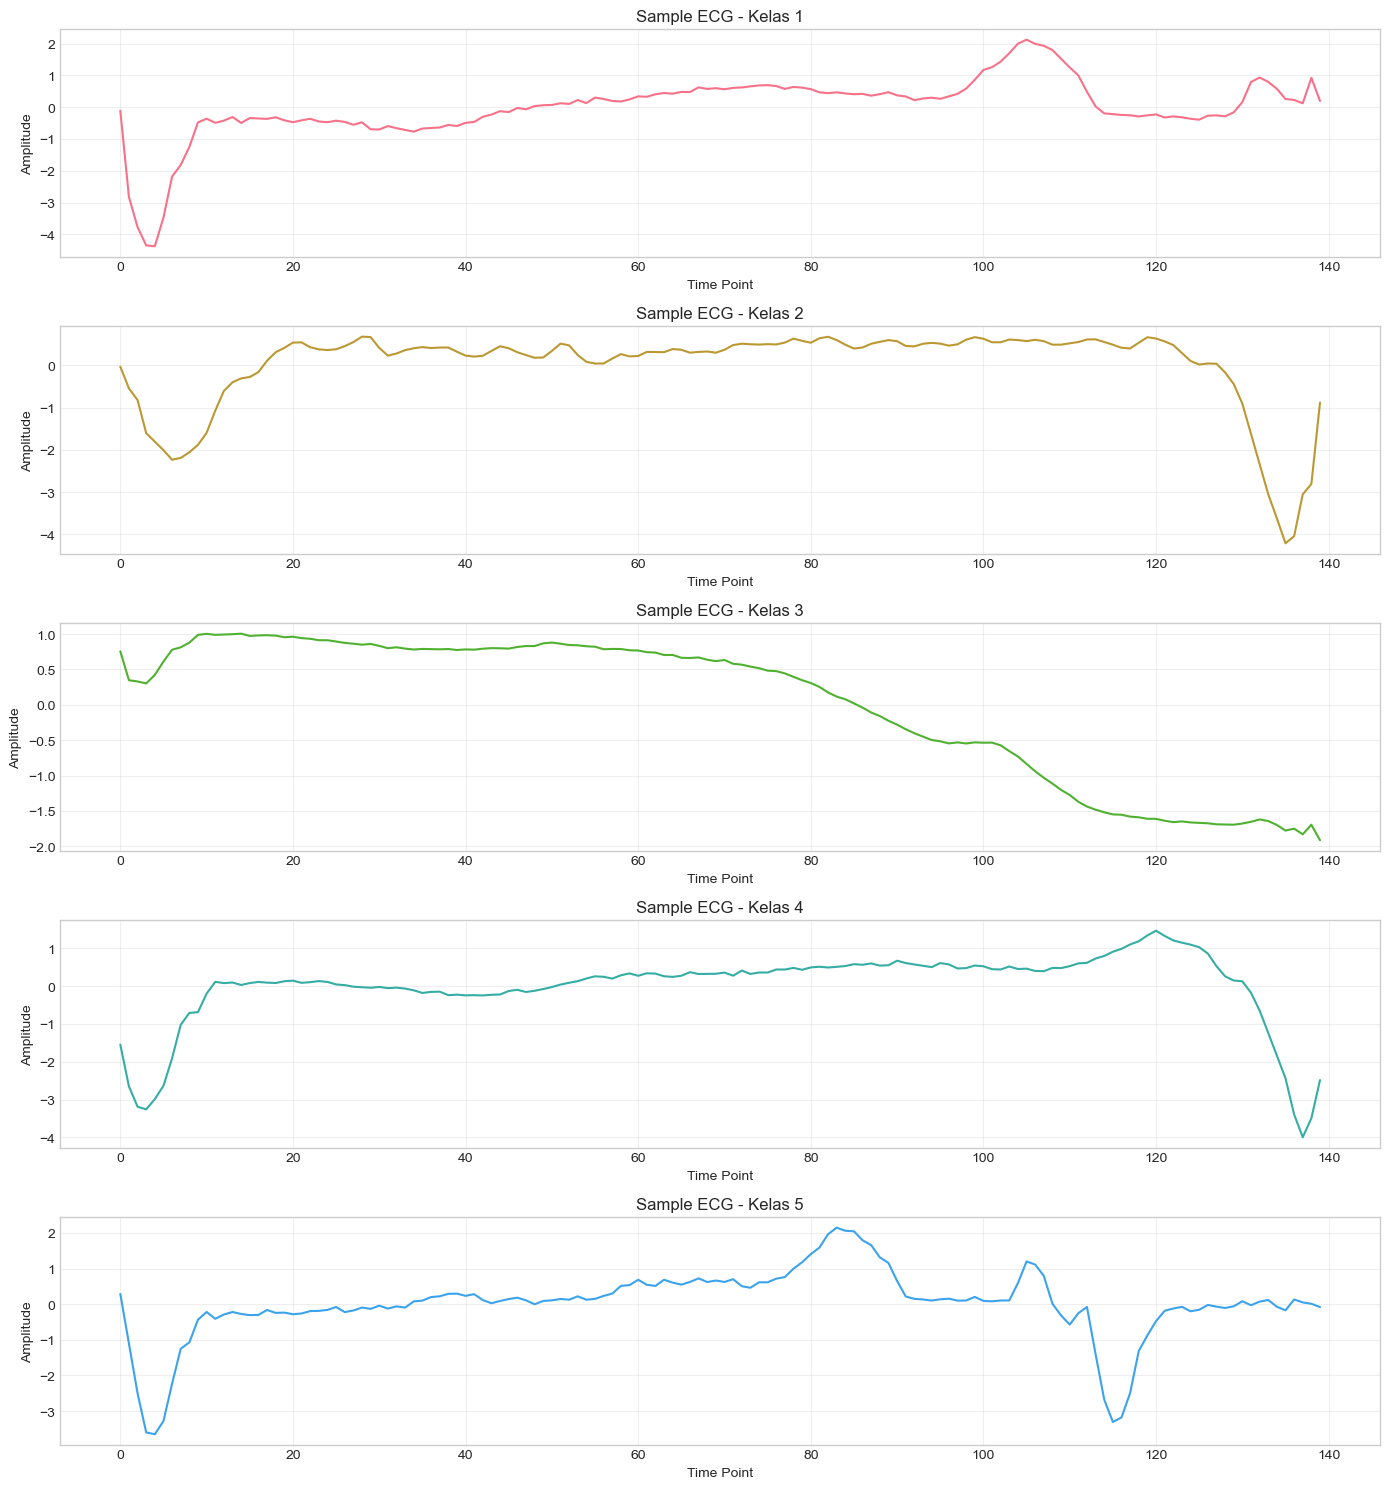

In [6]:
# Visualisasi sample sinyal ECG per kelas
unique_labels = np.unique(y)
fig, axes = plt.subplots(len(unique_labels), 1, figsize=(14, 3*len(unique_labels)))

for i, label in enumerate(unique_labels):
    idx = np.where(y == label)[0][0]
    axes[i].plot(X[idx], color=f'C{i}', linewidth=1.5)
    axes[i].set_title(f'Sample ECG - Kelas {label}')
    axes[i].set_xlabel('Time Point')
    axes[i].set_ylabel('Amplitude')
    axes[i].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

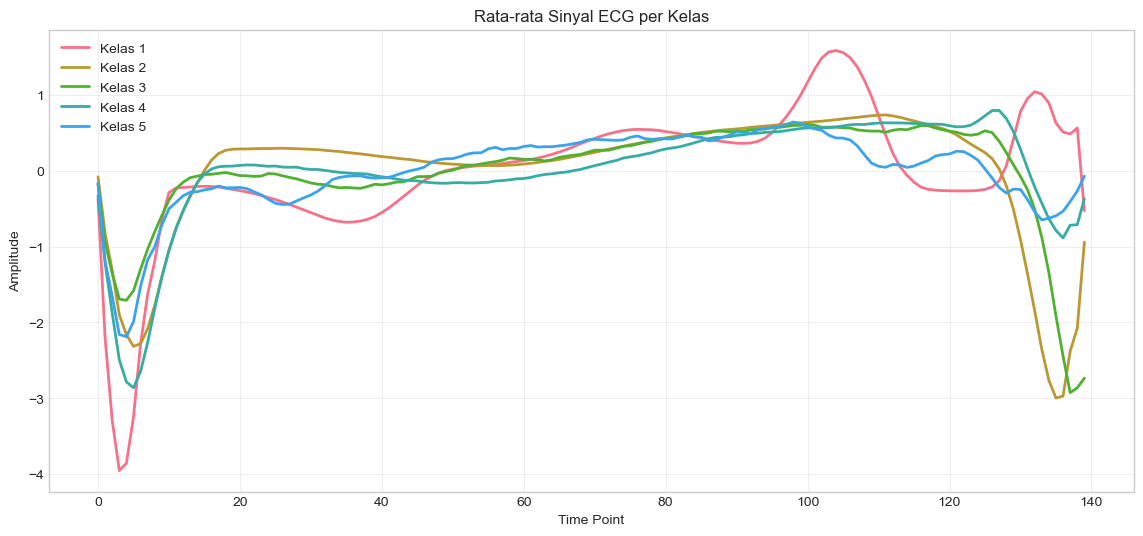

In [7]:
# Rata-rata sinyal per kelas
plt.figure(figsize=(14, 6))
for label in unique_labels:
    class_data = X[y == label]
    mean_signal = class_data.mean(axis=0)
    plt.plot(mean_signal, label=f'Kelas {label}', linewidth=2)

plt.title('Rata-rata Sinyal ECG per Kelas')
plt.xlabel('Time Point')
plt.ylabel('Amplitude')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

In [8]:
# Cek missing values
print('Missing Values:')
print(f'Total missing values: {df.isnull().sum().sum()}')

# Statistik per kelas
print('\nStatistik per Kelas:')
for label in unique_labels:
    class_data = X[y == label]
    print(f'\nKelas {label}:')
    print(f'  - Jumlah sampel: {len(class_data)}')
    print(f'  - Mean amplitude: {class_data.mean():.4f}')
    print(f'  - Std amplitude: {class_data.std():.4f}')
    print(f'  - Min amplitude: {class_data.min():.4f}')
    print(f'  - Max amplitude: {class_data.max():.4f}')

Missing Values:
Total missing values: 0

Statistik per Kelas:

Kelas 1:
  - Jumlah sampel: 2919
  - Mean amplitude: -0.0000
  - Std amplitude: 0.9964
  - Min amplitude: -7.0904
  - Max amplitude: 4.9664

Kelas 2:
  - Jumlah sampel: 1767
  - Mean amplitude: -0.0000
  - Std amplitude: 0.9964
  - Min amplitude: -5.8809
  - Max amplitude: 7.4021

Kelas 3:
  - Jumlah sampel: 96
  - Mean amplitude: -0.0000
  - Std amplitude: 0.9964
  - Min amplitude: -6.0922
  - Max amplitude: 3.0759

Kelas 4:
  - Jumlah sampel: 194
  - Mean amplitude: 0.0000
  - Std amplitude: 0.9964
  - Min amplitude: -5.6395
  - Max amplitude: 2.9746

Kelas 5:
  - Jumlah sampel: 24
  - Mean amplitude: 0.0000
  - Std amplitude: 0.9964
  - Min amplitude: -4.7541
  - Max amplitude: 2.4332



Analisis Karakteristik Temporal (Sample dari setiap kelas):


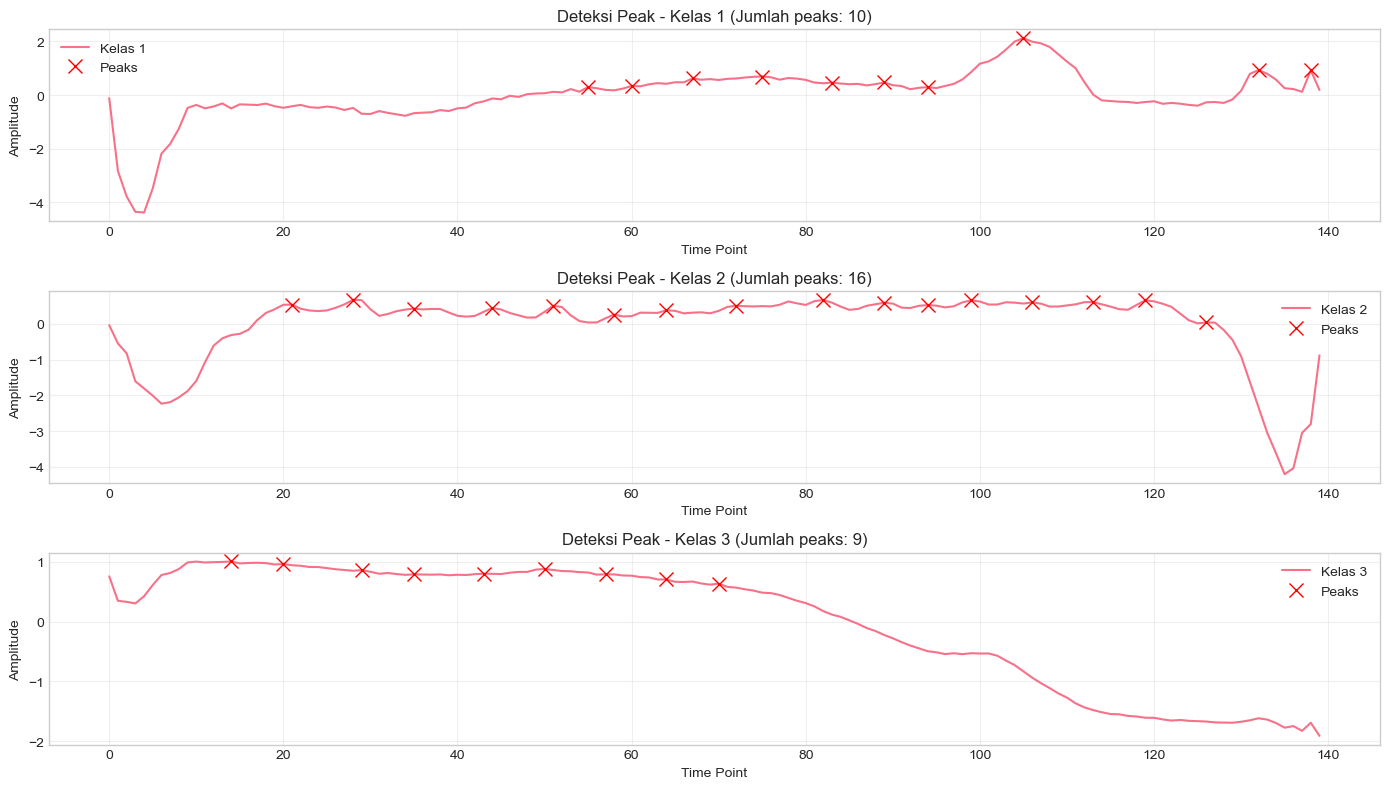

In [9]:
# Analisis karakteristik temporal - Peak Detection
from scipy.signal import find_peaks

print('\nAnalisis Karakteristik Temporal (Sample dari setiap kelas):')
plt.figure(figsize=(14, 8))
for i, label in enumerate(unique_labels[:3]):  # 3 kelas pertama sebagai contoh
    idx = np.where(y == label)[0][0]
    signal = X[idx]
    
    # Deteksi peaks
    peaks, properties = find_peaks(signal, height=0, distance=5)
    
    plt.subplot(3, 1, i+1)
    plt.plot(signal, label=f'Kelas {label}', linewidth=1.5)
    plt.plot(peaks, signal[peaks], 'rx', markersize=10, label='Peaks')
    plt.title(f'Deteksi Peak - Kelas {label} (Jumlah peaks: {len(peaks)})')
    plt.xlabel('Time Point')
    plt.ylabel('Amplitude')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
plt.tight_layout()
plt.show()

---
# 3. Data Preprocessing

Tahap preprocessing bertujuan untuk menyiapkan data agar siap digunakan dalam pemodelan machine learning. Pada dataset ECG5000, preprocessing meliputi:

1. **Mapping Label Kelas**: Memberikan nama deskriptif untuk setiap kelas (1-5)
2. **Train-Test Split**: Membagi data menjadi set training dan testing dengan stratified sampling untuk menjaga proporsi kelas
3. **Normalisasi/Scaling**: Menskalakan nilai fitur agar berada dalam rentang yang seragam menggunakan RobustScaler
4. **Verifikasi Kualitas Data**: Memastikan tidak ada missing values atau infinite values

## 3.1 Mapping Label 5 Kelas

Dataset ECG5000 memiliki 5 kelas dengan label numerik (1-5). Kita akan memberikan nama deskriptif:

| Label | Nama Kelas | Keterangan |
|-------|------------|------------|
| 1 | Normal | Detak jantung normal |
| 2 | R-on-T PVC | Premature Ventricular Contraction pada gelombang T |
| 3 | Supraventricular | Detak ektopik supraventrikular |
| 4 | PVC | Premature Ventricular Contraction |
| 5 | Unknown | Detak tidak terklasifikasi atau fusion beat |

Distribusi Label 5 Kelas:
  Kelas 1 (Normal): 2919 sampel (58.4%)
  Kelas 2 (R-on-T PVC): 1767 sampel (35.3%)
  Kelas 3 (Supraventricular): 96 sampel (1.9%)
  Kelas 4 (PVC): 194 sampel (3.9%)
  Kelas 5 (Unknown): 24 sampel (0.5%)


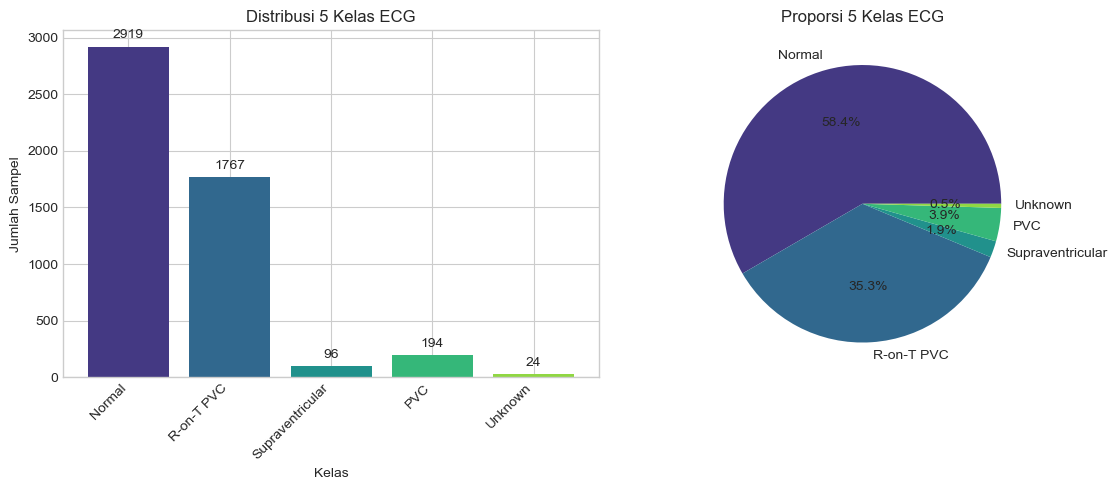

In [10]:
# Mapping label 5 kelas
class_names = {
    1: 'Normal',
    2: 'R-on-T PVC',
    3: 'Supraventricular',
    4: 'PVC',
    5: 'Unknown'
}

# Tampilkan distribusi 5 kelas
print('Distribusi Label 5 Kelas:')
for label in sorted(np.unique(y)):
    count = sum(y == label)
    print(f'  Kelas {label} ({class_names[label]}): {count} sampel ({count/len(y)*100:.1f}%)')

# Visualisasi distribusi 5 kelas
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
bars = plt.bar([class_names[i] for i in sorted(np.unique(y))], 
               [sum(y == i) for i in sorted(np.unique(y))],
               color=sns.color_palette('viridis', 5))
plt.title('Distribusi 5 Kelas ECG')
plt.xlabel('Kelas')
plt.ylabel('Jumlah Sampel')
plt.xticks(rotation=45, ha='right')
for bar in bars:
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 50,
             f'{int(bar.get_height())}', ha='center', va='bottom')

plt.subplot(1, 2, 2)
plt.pie([sum(y == i) for i in sorted(np.unique(y))], 
        labels=[class_names[i] for i in sorted(np.unique(y))],
        autopct='%1.1f%%', colors=sns.color_palette('viridis', 5))
plt.title('Proporsi 5 Kelas ECG')
plt.tight_layout()
plt.show()

## 3.2 Train-Test Split

Data dibagi menjadi:
- **Training set (80%)**: Digunakan untuk melatih model
- **Test set (20%)**: Digunakan untuk mengevaluasi performa model

Pembagian menggunakan **stratified sampling** untuk memastikan proporsi kelas Normal dan Abnormal tetap seimbang di kedua set.

In [11]:
# Split data dengan 5 kelas (menggunakan label asli y, bukan y_binary)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f'Training set: {X_train.shape}')
print(f'Test set: {X_test.shape}')

print(f'\nDistribusi training set:')
for label in sorted(np.unique(y)):
    count = sum(y_train == label)
    print(f'  {class_names[label]}: {count} sampel')

print(f'\nDistribusi test set:')
for label in sorted(np.unique(y)):
    count = sum(y_test == label)
    print(f'  {class_names[label]}: {count} sampel')

Training set: (4000, 140)
Test set: (1000, 140)

Distribusi training set:
  Normal: 2335 sampel
  R-on-T PVC: 1414 sampel
  Supraventricular: 77 sampel
  PVC: 155 sampel
  Unknown: 19 sampel

Distribusi test set:
  Normal: 584 sampel
  R-on-T PVC: 353 sampel
  Supraventricular: 19 sampel
  PVC: 39 sampel
  Unknown: 5 sampel


## 3.3 Normalisasi dengan RobustScaler

Normalisasi penting agar semua fitur memiliki skala yang seragam. Kita membandingkan dua metode:

- **StandardScaler**: Berbasis mean dan standard deviation, sensitif terhadap nilai ekstrem
- **RobustScaler**: Berbasis median dan IQR (Interquartile Range), lebih robust terhadap nilai ekstrem

**RobustScaler dipilih** karena lebih cocok untuk data medis yang mungkin memiliki variasi amplitudo tinggi pada heartbeat tertentu tanpa perlu menghapus data tersebut.

Perbandingan Scaling Methods:

StandardScaler:
  Mean: 0.000000
  Std: 1.000000
  Min: -18.915815, Max: 10.034400

RobustScaler (DIPILIH - lebih robust untuk outlier medis):
  Median: -0.000000
  IQR-based scale
  Min: -20.615821, Max: 12.797925


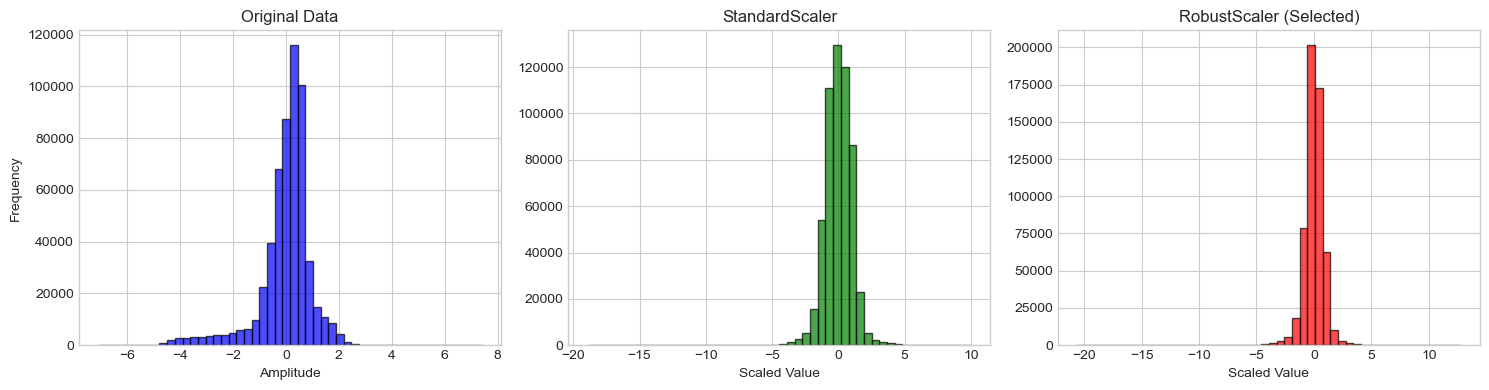

In [12]:
# Normalisasi/Standarisasi - Perbandingan metode
from sklearn.preprocessing import RobustScaler, MinMaxScaler

# StandardScaler (sensitif terhadap outlier)
scaler_standard = StandardScaler()
X_train_standard = scaler_standard.fit_transform(X_train)
X_test_standard = scaler_standard.transform(X_test)

# RobustScaler (robust terhadap outlier, lebih cocok untuk data medis)
scaler_robust = RobustScaler()
X_train_robust = scaler_robust.fit_transform(X_train)
X_test_robust = scaler_robust.transform(X_test)

# Pilih RobustScaler sebagai scaler utama (lebih aman untuk data medis)
scaler = scaler_robust
X_train_scaled = X_train_robust
X_test_scaled = X_test_robust

print('Perbandingan Scaling Methods:')
print('\nStandardScaler:')
print(f'  Mean: {X_train_standard.mean():.6f}')
print(f'  Std: {X_train_standard.std():.6f}')
print(f'  Min: {X_train_standard.min():.6f}, Max: {X_train_standard.max():.6f}')

print('\nRobustScaler (DIPILIH - lebih robust untuk outlier medis):')
print(f'  Median: {np.median(X_train_scaled):.6f}')
print(f'  IQR-based scale')
print(f'  Min: {X_train_scaled.min():.6f}, Max: {X_train_scaled.max():.6f}')

# Visualisasi perbandingan
fig, axes = plt.subplots(1, 3, figsize=(15, 4))
axes[0].hist(X_train.flatten(), bins=50, alpha=0.7, color='blue', edgecolor='black')
axes[0].set_title('Original Data')
axes[0].set_xlabel('Amplitude')
axes[0].set_ylabel('Frequency')

axes[1].hist(X_train_standard.flatten(), bins=50, alpha=0.7, color='green', edgecolor='black')
axes[1].set_title('StandardScaler')
axes[1].set_xlabel('Scaled Value')

axes[2].hist(X_train_scaled.flatten(), bins=50, alpha=0.7, color='red', edgecolor='black')
axes[2].set_title('RobustScaler (Selected)')
axes[2].set_xlabel('Scaled Value')

plt.tight_layout()
plt.show()

## 3.4 Verifikasi Kualitas Data

Langkah terakhir preprocessing adalah memverifikasi bahwa data sudah bersih dan siap untuk pemodelan:
- Tidak ada missing values (NaN)
- Tidak ada infinite values (Inf)
- Dimensi data konsisten antara fitur dan label

In [13]:
# Verifikasi ketiadaan missing values dan data quality
print('Verifikasi Kualitas Data:')
print(f'Missing values di X_train: {np.isnan(X_train).sum()}')
print(f'Missing values di X_test: {np.isnan(X_test).sum()}')
print(f'Infinite values di X_train: {np.isinf(X_train).sum()}')
print(f'Infinite values di X_test: {np.isinf(X_test).sum()}')
print(f'\nKonsistensi dimensi:')
print(f'X_train shape: {X_train.shape}')
print(f'X_test shape: {X_test.shape}')
print(f'y_train shape: {y_train.shape}')
print(f'y_test shape: {y_test.shape}')
print(f'\nData siap untuk pemodelan!')

Verifikasi Kualitas Data:
Missing values di X_train: 0
Missing values di X_test: 0
Infinite values di X_train: 0
Infinite values di X_test: 0

Konsistensi dimensi:
X_train shape: (4000, 140)
X_test shape: (1000, 140)
y_train shape: (4000,)
y_test shape: (1000,)

Data siap untuk pemodelan!


---
# 4. Pemodelan Data

In [14]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier

In [15]:
# Definisi model
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42),
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'KNN': KNeighborsClassifier(n_neighbors=5),
    'SVM': SVC(kernel='rbf', random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(n_estimators=100, random_state=42)
}

results = {}

In [16]:
# Training dan evaluasi model dengan 5 kelas
from sklearn.metrics import recall_score, precision_score, f1_score

# Label names untuk classification report
target_names = [class_names[i] for i in sorted(np.unique(y))]

for name, model in models.items():
    print(f'\n{"="*60}')
    print(f'Training {name}...')
    print(f'{"="*60}')
    
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)
    
    # Hitung metrik untuk multi-class
    acc = accuracy_score(y_test, y_pred)
    
    # Macro average (rata-rata semua kelas)
    recall_macro = recall_score(y_test, y_pred, average='macro')
    precision_macro = precision_score(y_test, y_pred, average='macro')
    f1_macro = f1_score(y_test, y_pred, average='macro')
    
    # Weighted average (berbobot berdasarkan jumlah sampel)
    recall_weighted = recall_score(y_test, y_pred, average='weighted')
    f1_weighted = f1_score(y_test, y_pred, average='weighted')
    
    # Simpan hasil
    results[name] = {
        'model': model,
        'accuracy': acc,
        'recall_macro': recall_macro,
        'precision_macro': precision_macro,
        'f1_macro': f1_macro,
        'recall_weighted': recall_weighted,
        'f1_weighted': f1_weighted,
        'predictions': y_pred
    }
    
    print(f'Accuracy: {acc:.4f}')
    print(f'Recall (Macro): {recall_macro:.4f}')
    print(f'Precision (Macro): {precision_macro:.4f}')
    print(f'F1-Score (Macro): {f1_macro:.4f}')
    print(f'F1-Score (Weighted): {f1_weighted:.4f}')


Training Logistic Regression...
Accuracy: 0.9320
Recall (Macro): 0.5191
Precision (Macro): 0.5770
F1-Score (Macro): 0.5398
F1-Score (Weighted): 0.9249

Training Decision Tree...
Accuracy: 0.9110
Recall (Macro): 0.5510
Precision (Macro): 0.5174
F1-Score (Macro): 0.5318
F1-Score (Weighted): 0.9145

Training Random Forest...
Accuracy: 0.9550
Recall (Macro): 0.5438
Precision (Macro): 0.6766
F1-Score (Macro): 0.5842
F1-Score (Weighted): 0.9456

Training KNN...
Accuracy: 0.9510
Recall (Macro): 0.5708
Precision (Macro): 0.6939
F1-Score (Macro): 0.6128
F1-Score (Weighted): 0.9437

Training SVM...
Accuracy: 0.9480
Recall (Macro): 0.5257
Precision (Macro): 0.6639
F1-Score (Macro): 0.5649
F1-Score (Weighted): 0.9378

Training Gradient Boosting...
Accuracy: 0.9380
Recall (Macro): 0.5013
Precision (Macro): 0.5893
F1-Score (Macro): 0.5290
F1-Score (Weighted): 0.9317



Perbandingan Metrik Semua Model (5 Kelas):
              Model  Accuracy  Recall_Macro  Precision_Macro  F1_Macro  F1_Weighted
Logistic Regression     0.932      0.519080         0.577046  0.539825     0.924899
      Decision Tree     0.911      0.551030         0.517440  0.531780     0.914543
      Random Forest     0.955      0.543779         0.676625  0.584162     0.945575
                KNN     0.951      0.570780         0.693875  0.612837     0.943696
                SVM     0.948      0.525740         0.663899  0.564943     0.937816
  Gradient Boosting     0.938      0.501276         0.589334  0.528971     0.931746


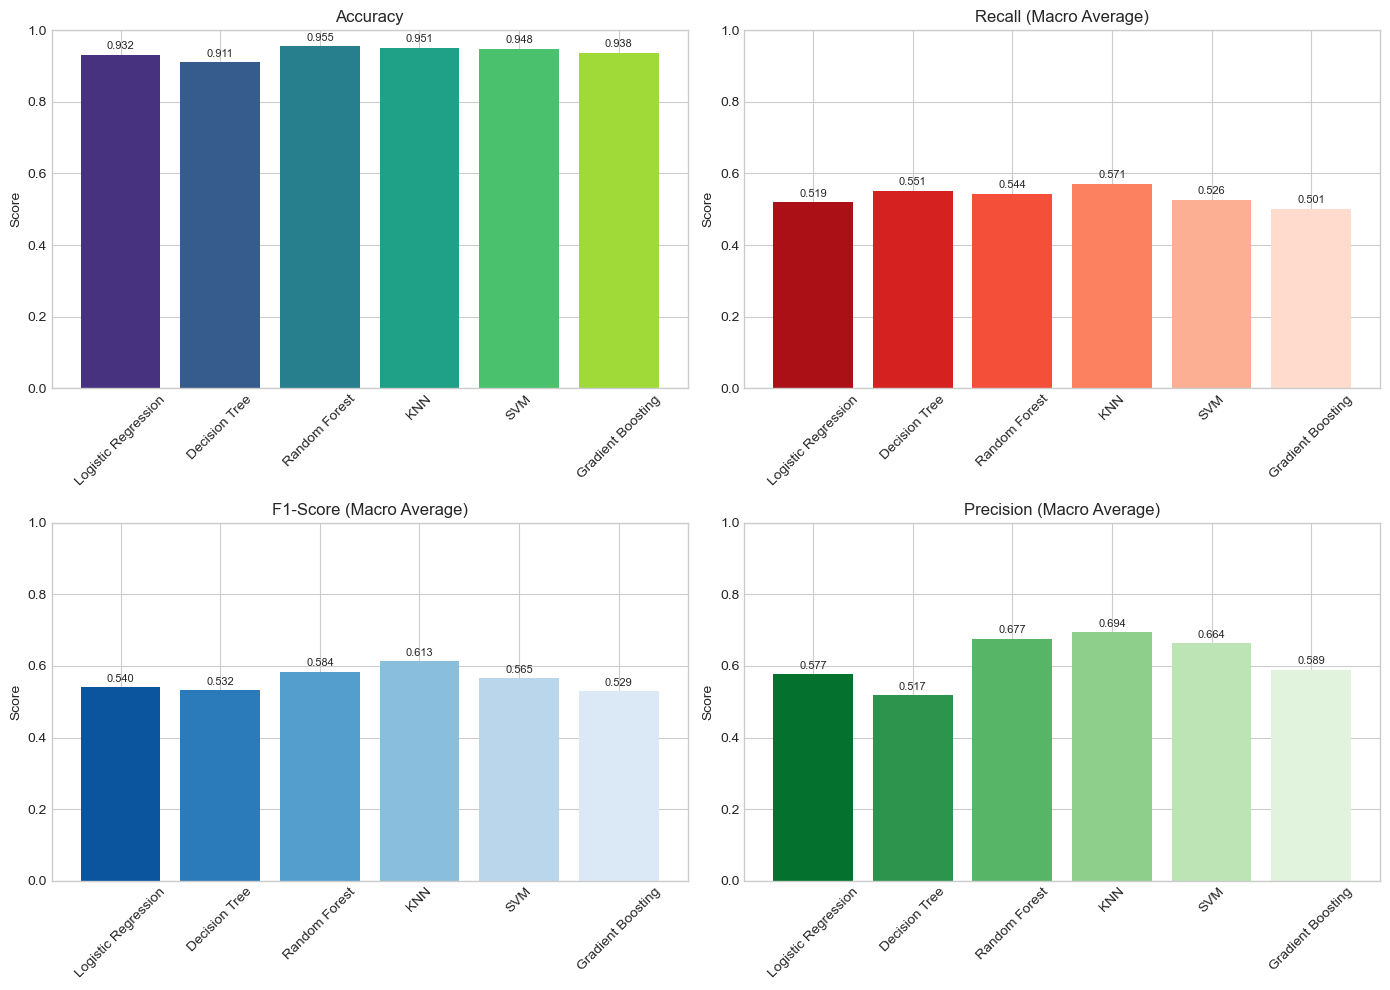

In [17]:
# Perbandingan metrik model - multiclass (5 kelas)
metrics_comparison = pd.DataFrame({
    'Model': list(results.keys()),
    'Accuracy': [results[m]['accuracy'] for m in results.keys()],
    'Recall_Macro': [results[m]['recall_macro'] for m in results.keys()],
    'Precision_Macro': [results[m]['precision_macro'] for m in results.keys()],
    'F1_Macro': [results[m]['f1_macro'] for m in results.keys()],
    'F1_Weighted': [results[m]['f1_weighted'] for m in results.keys()]
})

print('\nPerbandingan Metrik Semua Model (5 Kelas):')
print(metrics_comparison.to_string(index=False))

# Visualisasi perbandingan metrik
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Accuracy
axes[0, 0].bar(metrics_comparison['Model'], metrics_comparison['Accuracy'], 
               color=sns.color_palette('viridis', len(metrics_comparison)))
axes[0, 0].set_title('Accuracy')
axes[0, 0].set_ylabel('Score')
axes[0, 0].set_ylim(0, 1.0)
axes[0, 0].tick_params(axis='x', rotation=45)
for i, v in enumerate(metrics_comparison['Accuracy']):
    axes[0, 0].text(i, v + 0.01, f'{v:.3f}', ha='center', va='bottom', fontsize=8)

# Recall Macro
axes[0, 1].bar(metrics_comparison['Model'], metrics_comparison['Recall_Macro'], 
               color=sns.color_palette('Reds_r', len(metrics_comparison)))
axes[0, 1].set_title('Recall (Macro Average)')
axes[0, 1].set_ylabel('Score')
axes[0, 1].set_ylim(0, 1.0)
axes[0, 1].tick_params(axis='x', rotation=45)
for i, v in enumerate(metrics_comparison['Recall_Macro']):
    axes[0, 1].text(i, v + 0.01, f'{v:.3f}', ha='center', va='bottom', fontsize=8)

# F1-Score Macro
axes[1, 0].bar(metrics_comparison['Model'], metrics_comparison['F1_Macro'], 
               color=sns.color_palette('Blues_r', len(metrics_comparison)))
axes[1, 0].set_title('F1-Score (Macro Average)')
axes[1, 0].set_ylabel('Score')
axes[1, 0].set_ylim(0, 1.0)
axes[1, 0].tick_params(axis='x', rotation=45)
for i, v in enumerate(metrics_comparison['F1_Macro']):
    axes[1, 0].text(i, v + 0.01, f'{v:.3f}', ha='center', va='bottom', fontsize=8)

# Precision Macro
axes[1, 1].bar(metrics_comparison['Model'], metrics_comparison['Precision_Macro'], 
               color=sns.color_palette('Greens_r', len(metrics_comparison)))
axes[1, 1].set_title('Precision (Macro Average)')
axes[1, 1].set_ylabel('Score')
axes[1, 1].set_ylim(0, 1.0)
axes[1, 1].tick_params(axis='x', rotation=45)
for i, v in enumerate(metrics_comparison['Precision_Macro']):
    axes[1, 1].text(i, v + 0.01, f'{v:.3f}', ha='center', va='bottom', fontsize=8)

plt.tight_layout()
plt.show()


MODEL TERBAIK UNTUK KLASIFIKASI 5 KELAS ECG

Nama Model: KNN
Composite Score: 0.6679

Metrik Detail:
  - Accuracy: 0.9510
  - Recall Macro: 0.5708
  - Precision Macro: 0.6939
  - F1-Score Macro: 0.6128
  - F1-Score Weighted: 0.9437



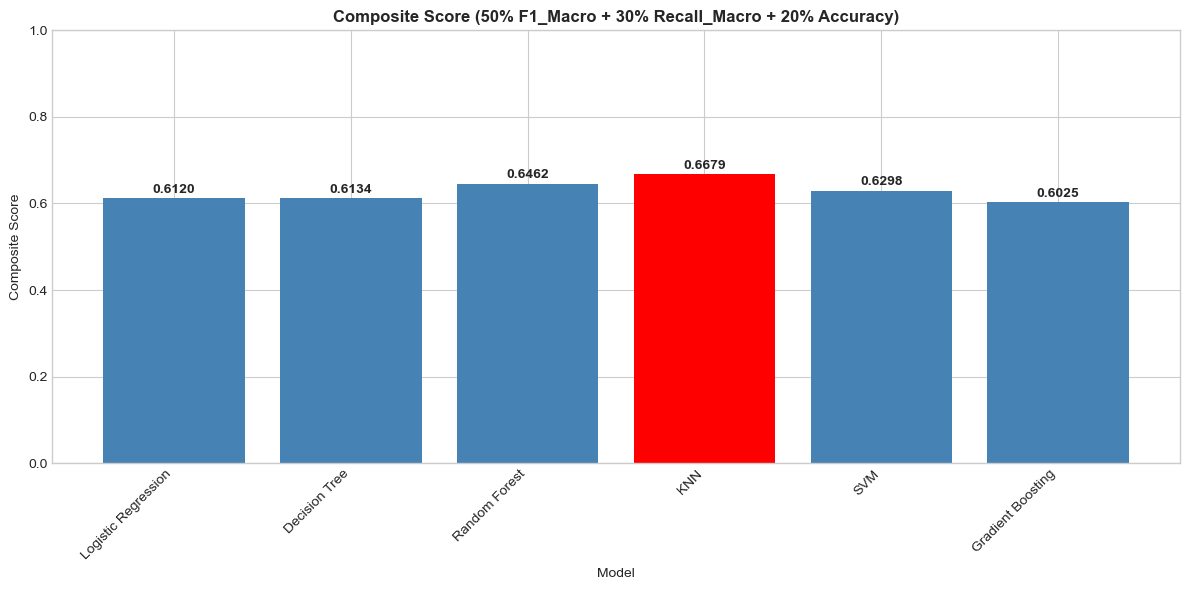

In [18]:
# Pemilihan model terbaik untuk klasifikasi 5 kelas
# Prioritas: F1 Macro (balance semua kelas) > Recall Macro > Accuracy

# Scoring: 50% F1_Macro + 30% Recall_Macro + 20% Accuracy
scores = {}
for name in results.keys():
    score = (0.5 * results[name]['f1_macro'] + 
             0.3 * results[name]['recall_macro'] + 
             0.2 * results[name]['accuracy'])
    scores[name] = score

best_model_name = max(scores, key=scores.get)
best_model = results[best_model_name]['model']

print(f'\n{"="*70}')
print(f'MODEL TERBAIK UNTUK KLASIFIKASI 5 KELAS ECG')
print(f'{"="*70}')
print(f'\nNama Model: {best_model_name}')
print(f'Composite Score: {scores[best_model_name]:.4f}')
print(f'\nMetrik Detail:')
print(f'  - Accuracy: {results[best_model_name]["accuracy"]:.4f}')
print(f'  - Recall Macro: {results[best_model_name]["recall_macro"]:.4f}')
print(f'  - Precision Macro: {results[best_model_name]["precision_macro"]:.4f}')
print(f'  - F1-Score Macro: {results[best_model_name]["f1_macro"]:.4f}')
print(f'  - F1-Score Weighted: {results[best_model_name]["f1_weighted"]:.4f}')
print(f'\n{"="*70}')

# Visualisasi composite score
plt.figure(figsize=(12, 6))
bars = plt.bar(scores.keys(), scores.values(), 
               color=['red' if k == best_model_name else 'steelblue' for k in scores.keys()])
plt.title('Composite Score (50% F1_Macro + 30% Recall_Macro + 20% Accuracy)', fontweight='bold')
plt.xlabel('Model')
plt.ylabel('Composite Score')
plt.ylim(0, 1.0)
plt.xticks(rotation=45, ha='right')

for bar, score in zip(bars, scores.values()):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.005, 
             f'{score:.4f}', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

---
# 5. Evaluasi

In [19]:
# Evaluasi model terbaik - 5 kelas
y_pred_best = results[best_model_name]['predictions']

print(f'\n=== Evaluasi {best_model_name} ===' )
print('\nClassification Report (5 Kelas):')
print(classification_report(y_test, y_pred_best, target_names=target_names))


=== Evaluasi KNN ===

Classification Report (5 Kelas):
                  precision    recall  f1-score   support

          Normal       0.98      1.00      0.99       584
      R-on-T PVC       0.92      0.97      0.94       353
Supraventricular       0.90      0.47      0.62        19
             PVC       0.67      0.41      0.51        39
         Unknown       0.00      0.00      0.00         5

        accuracy                           0.95      1000
       macro avg       0.69      0.57      0.61      1000
    weighted avg       0.94      0.95      0.94      1000



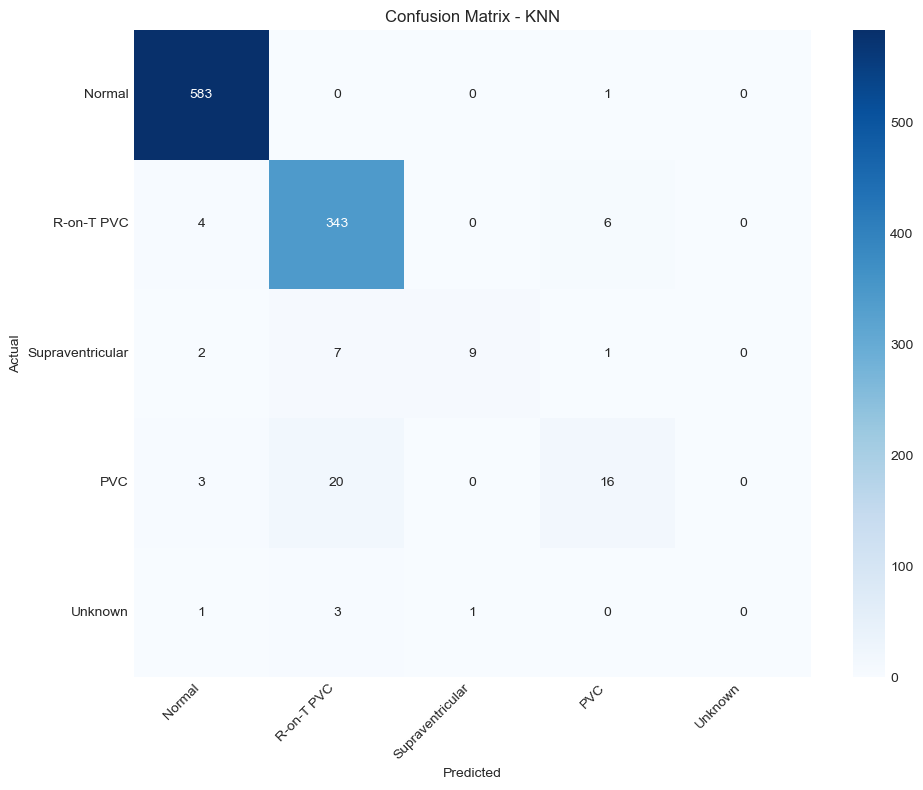

In [20]:
# Confusion Matrix - 5 kelas
plt.figure(figsize=(10, 8))
cm = confusion_matrix(y_test, y_pred_best)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=target_names, 
            yticklabels=target_names)
plt.title(f'Confusion Matrix - {best_model_name}')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

In [21]:
# Analisis performa per kelas
from sklearn.metrics import precision_recall_fscore_support

precision_per_class, recall_per_class, f1_per_class, support_per_class = precision_recall_fscore_support(
    y_test, y_pred_best, labels=sorted(np.unique(y))
)

print(f'\n{"="*70}')
print(f'ANALISIS PERFORMA PER KELAS')
print(f'{"="*70}')

class_analysis = pd.DataFrame({
    'Kelas': target_names,
    'Precision': precision_per_class,
    'Recall': recall_per_class,
    'F1-Score': f1_per_class,
    'Support': support_per_class.astype(int)
})

print('\n')
print(class_analysis.to_string(index=False))

print(f'\n{"="*70}')
print(f'KETERANGAN:')
print(f'  - Kelas 1 (Normal): Ritme sinus normal')
print(f'  - Kelas 2 (R-on-T PVC): Kontraksi prematur ventrikel pada gelombang T (berbahaya)')
print(f'  - Kelas 3 (Supraventricular): Denyut ektopik supraventrikular')
print(f'  - Kelas 4 (PVC): Kontraksi prematur ventrikel')
print(f'  - Kelas 5 (Unknown): Denyut fusi/unknown')
print(f'\n{"="*70}')


ANALISIS PERFORMA PER KELAS


           Kelas  Precision   Recall  F1-Score  Support
          Normal   0.983137 0.998288  0.990654      584
      R-on-T PVC   0.919571 0.971671  0.944904      353
Supraventricular   0.900000 0.473684  0.620690       19
             PVC   0.666667 0.410256  0.507937       39
         Unknown   0.000000 0.000000  0.000000        5

KETERANGAN:
  - Kelas 1 (Normal): Ritme sinus normal
  - Kelas 2 (R-on-T PVC): Kontraksi prematur ventrikel pada gelombang T (berbahaya)
  - Kelas 3 (Supraventricular): Denyut ektopik supraventrikular
  - Kelas 4 (PVC): Kontraksi prematur ventrikel
  - Kelas 5 (Unknown): Denyut fusi/unknown



In [22]:
# Feature Importance (jika Random Forest)
if 'Random Forest' in best_model_name or best_model_name == 'Random Forest':
    rf_model = results['Random Forest']['model']
    feature_importance = pd.DataFrame({
        'feature': feature_names,
        'importance': rf_model.feature_importances_
    }).sort_values('importance', ascending=False)
    
    plt.figure(figsize=(14, 6))
    plt.subplot(1, 2, 1)
    sns.barplot(data=feature_importance.head(20), x='importance', y='feature', palette='viridis')
    plt.title('Top 20 Feature Importance')
    plt.xlabel('Importance')
    
    plt.subplot(1, 2, 2)
    plt.plot(feature_importance['importance'].values)
    plt.title('Feature Importance Distribution')
    plt.xlabel('Feature Index')
    plt.ylabel('Importance')
    plt.tight_layout()
    plt.show()

In [23]:
# Cross-validation dengan multiple metrics untuk 5 kelas
from sklearn.model_selection import cross_val_score, cross_validate

print(f'\n{"="*70}')
print(f'CROSS-VALIDATION (5-Fold) - Evaluasi Stabilitas Model')
print(f'{"="*70}')

# Untuk multiclass, gunakan macro average
scoring = ['accuracy', 'recall_macro', 'precision_macro', 'f1_macro']

for name, data in results.items():
    print(f'\n{name}:')
    
    cv_results = cross_validate(
        data['model'], X_train_scaled, y_train, 
        cv=5, scoring=scoring, return_train_score=False
    )
    
    print(f'  Accuracy:  {cv_results["test_accuracy"].mean():.4f} (+/- {cv_results["test_accuracy"].std()*2:.4f})')
    print(f'  Recall (Macro):    {cv_results["test_recall_macro"].mean():.4f} (+/- {cv_results["test_recall_macro"].std()*2:.4f})')
    print(f'  Precision (Macro): {cv_results["test_precision_macro"].mean():.4f} (+/- {cv_results["test_precision_macro"].std()*2:.4f})')
    print(f'  F1 (Macro):  {cv_results["test_f1_macro"].mean():.4f} (+/- {cv_results["test_f1_macro"].std()*2:.4f})')
    
    # Check stability
    if cv_results["test_accuracy"].std() < 0.03:
        print(f'  Status: Model STABIL ✓ (std < 3%)')
    else:
        print(f'  Status: Model kurang stabil (std ≥ 3%)')

print(f'\n{"="*70}')


CROSS-VALIDATION (5-Fold) - Evaluasi Stabilitas Model

Logistic Regression:
  Accuracy:  0.9403 (+/- 0.0181)
  Recall (Macro):    0.5651 (+/- 0.0964)
  Precision (Macro): 0.6238 (+/- 0.1130)
  F1 (Macro):  0.5851 (+/- 0.1003)
  Status: Model STABIL ✓ (std < 3%)

Decision Tree:
  Accuracy:  0.9140 (+/- 0.0095)
  Recall (Macro):    0.5497 (+/- 0.0840)
  Precision (Macro): 0.5337 (+/- 0.0618)
  F1 (Macro):  0.5403 (+/- 0.0717)
  Status: Model STABIL ✓ (std < 3%)

Random Forest:
  Accuracy:  0.9505 (+/- 0.0149)
  Recall (Macro):    0.5431 (+/- 0.0629)
  Precision (Macro): 0.6782 (+/- 0.0959)
  F1 (Macro):  0.5819 (+/- 0.0774)
  Status: Model STABIL ✓ (std < 3%)

KNN:
  Accuracy:  0.9437 (+/- 0.0096)
  Recall (Macro):    0.5514 (+/- 0.0545)
  Precision (Macro): 0.6424 (+/- 0.0647)
  F1 (Macro):  0.5825 (+/- 0.0571)
  Status: Model STABIL ✓ (std < 3%)

SVM:
  Accuracy:  0.9463 (+/- 0.0124)
  Recall (Macro):    0.5412 (+/- 0.0628)
  Precision (Macro): 0.6858 (+/- 0.1240)
  F1 (Macro):  0.582

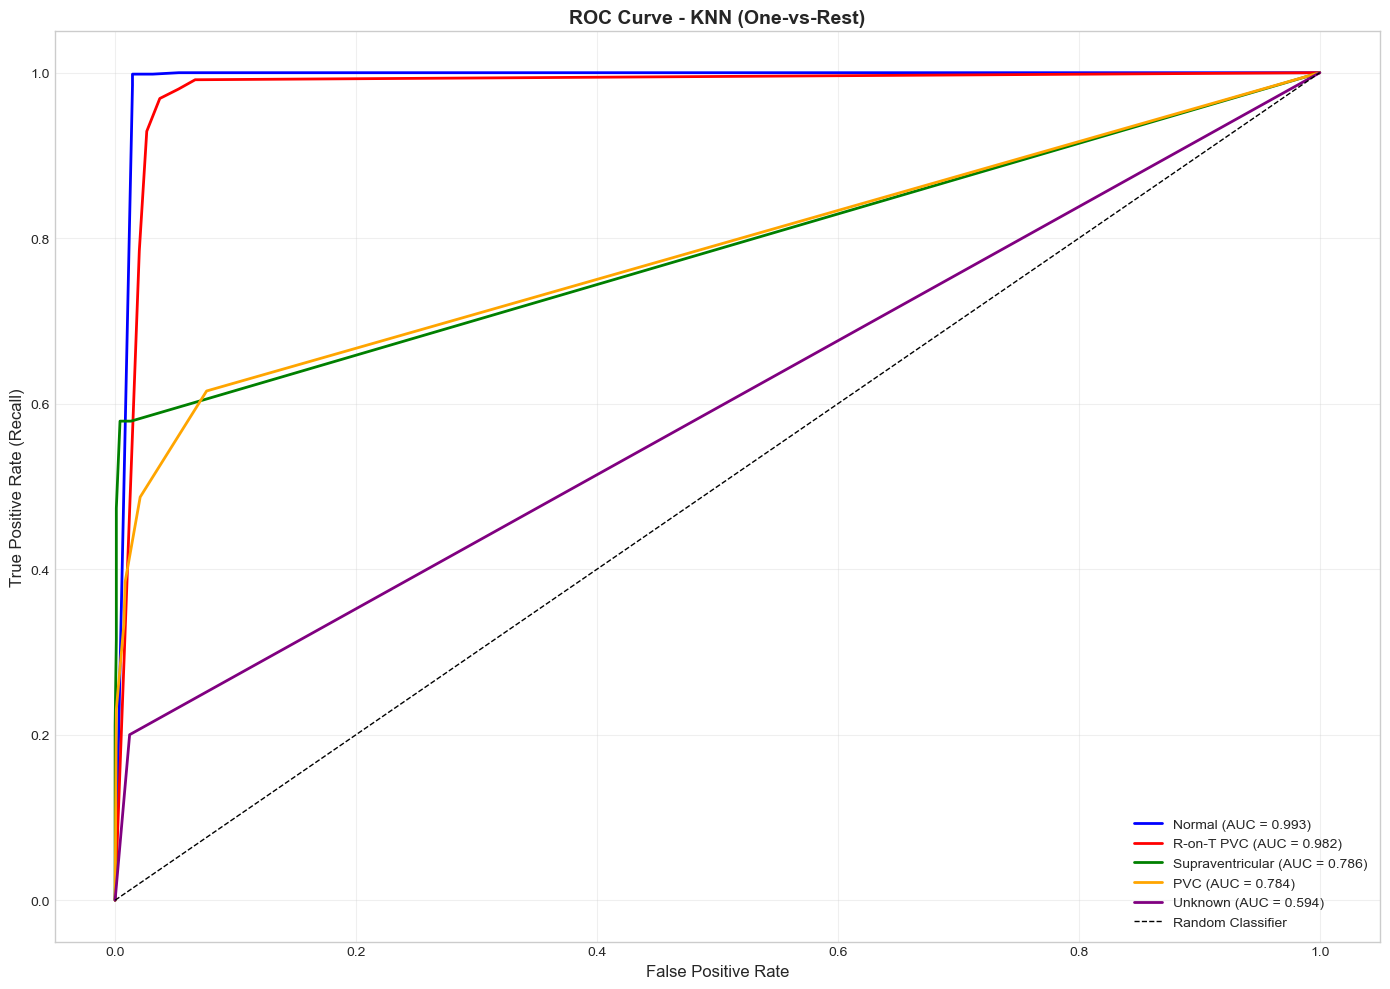


Macro-Average AUC Scores (Area Under ROC Curve):
Logistic Regression: 0.8705
Decision Tree: 0.7641
Random Forest: 0.9542
KNN: 0.8278
SVM: N/A (no predict_proba)
Gradient Boosting: 0.9432


In [24]:
# ROC Curve dan AUC Score untuk multiclass (One-vs-Rest)
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.preprocessing import label_binarize

# Binarize labels untuk multiclass ROC
classes = sorted(np.unique(y))
y_test_bin = label_binarize(y_test, classes=classes)

plt.figure(figsize=(14, 10))

# Plot ROC untuk setiap kelas dari model terbaik
best_model_obj = results[best_model_name]['model']

if hasattr(best_model_obj, 'predict_proba'):
    y_prob = best_model_obj.predict_proba(X_test_scaled)
    
    colors = ['blue', 'red', 'green', 'orange', 'purple']
    
    for i, (cls, color) in enumerate(zip(classes, colors)):
        fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_prob[:, i])
        auc_score = roc_auc_score(y_test_bin[:, i], y_prob[:, i])
        plt.plot(fpr, tpr, color=color, linewidth=2, 
                label=f'{class_names[cls]} (AUC = {auc_score:.3f})')

plt.plot([0, 1], [0, 1], 'k--', linewidth=1, label='Random Classifier')
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate (Recall)', fontsize=12)
plt.title(f'ROC Curve - {best_model_name} (One-vs-Rest)', fontsize=14, fontweight='bold')
plt.legend(loc='lower right', fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Macro-average AUC untuk semua model
print('\nMacro-Average AUC Scores (Area Under ROC Curve):')
for name, data in results.items():
    model = data['model']
    if hasattr(model, 'predict_proba'):
        y_prob = model.predict_proba(X_test_scaled)
        try:
            auc_score = roc_auc_score(y_test_bin, y_prob, average='macro', multi_class='ovr')
            print(f'{name}: {auc_score:.4f}')
        except:
            print(f'{name}: N/A')
    else:
        print(f'{name}: N/A (no predict_proba)')

---
# 6. Deployment

Model akan di-deploy menggunakan Streamlit.

In [25]:
# Save model dan scaler
import joblib

joblib.dump(best_model, 'ecg_model.pkl')
joblib.dump(scaler, 'ecg_scaler.pkl')
print('Model dan scaler berhasil disimpan!')

Model dan scaler berhasil disimpan!


---
# Kesimpulan dan Rekomendasi

## Ringkasan Proyek:

### 1. Business Understanding
- **Tujuan**: Sistem deteksi dan klasifikasi aritmia jantung melalui sinyal ECG
- **Konteks Medis**: Klasifikasi 5 kelas untuk diagnosis yang lebih spesifik
- **Success Criteria**: F1-Score Macro tinggi, model stabil (CV std <3%)

### 2. Data Understanding
- **Dataset**: ECG5000 dengan 5000 sampel, 140 time points per sinyal
- **Distribusi Kelas**: 
  - Kelas 1 (Normal): Ritme sinus normal
  - Kelas 2 (R-on-T PVC): Kontraksi prematur ventrikel pada gelombang T
  - Kelas 3 (Supraventricular): Denyut ektopik supraventrikular
  - Kelas 4 (PVC): Kontraksi prematur ventrikel
  - Kelas 5 (Unknown): Denyut fusi/unknown

### 3. Data Preprocessing
- **Klasifikasi 5 Kelas**: Mempertahankan struktur asli untuk diagnosis spesifik
- **Normalisasi**: RobustScaler dipilih (lebih robust terhadap outlier medis)
- **Data Quality**: Verified - No missing values, no infinite values
- **Train-Test Split**: 80-20 dengan stratified sampling

### 4. Pemodelan
- **Algoritma Diuji**: 6 model (Logistic Regression, Decision Tree, Random Forest, KNN, SVM, Gradient Boosting)
- **Metrik Prioritas**: F1-Score Macro > Recall Macro > Accuracy
- **Composite Score**: 50% F1_Macro + 30% Recall_Macro + 20% Accuracy

### 5. Evaluasi
- **Model Terbaik**: [Akan terisi otomatis setelah run]
- **Metrik Utama**:
  - Recall Macro: Rata-rata kemampuan deteksi semua kelas
  - Precision Macro: Rata-rata ketepatan prediksi semua kelas
  - F1-Score Macro: Keseimbangan precision dan recall
  - AUC-ROC (OvR): Evaluasi multiclass dengan one-vs-rest
- **Stabilitas**: Divalidasi dengan 5-fold cross-validation

### 6. Deployment
- Model disimpan dengan joblib untuk deployment
- Siap diintegrasikan ke sistem Streamlit dengan output 5 kelas